# Demonstration RAG-Eval


In [1]:
from rag_eval.protocol import LLMClient
from rag_eval.client import AzureClient
from rag_eval.components import ClaimExtractor, EntailmentJudge
from rag_eval.data_models import EvalContainer, ClaimVerdict
from rag_eval.evaluators import AnswerPrecisionEvaluator, RetrievalPrecisionEvaluator
from rag_eval.coordinator import RAGEvaluator
from rag_eval.helpers import _safe_json
import json
from data.rag_eval_samples import test_examples
from openai import AzureOpenAI
from dotenv import load_dotenv
import os

c:\Users\ANDERBE\AI-Agent-POC-git\AI-Agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# Indexing

Check if agent module actually works.

In [3]:
# load agent and pipeline for indexing docs
import agent.main as main
from rag.indexing import pdf_files, index_pipeline

PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


In [4]:
index_pipeline.run({"converter": {"sources": pdf_files}})

incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00,  2.26it/s]


{'writer': {'documents_written': 51}}

## RAG-Loop
Loop which passes questions to agent and extracts generated answers alongside retrieved contexts (plain text). Combines them with ground truth and query to form `EvalContainer`-object.

In [5]:
# quick test of my query_gt_extractor function
from src.rag_eval.helpers import query_gt_extractor

queries, gt = query_gt_extractor(path="data/agent_eval_questions.json", tokenize=False)
print(len(queries), len(gt))


40 40


This code cell creates a RAG-loop for the agent. It:  
- feeds the questions from the test battery to the agent  
- extracts the generated answer and retrieved context from the RAG-call
- returns a list of `EvalContainer`-objects storing question, ground truth, generated answer and retrieved context

It thus lays the foundation for the `RAGEevaluator`. 

In [5]:
main.food_agent(user_input="Vergleiche den Preis f√ºr Espresso von Anton's Pizza und bei Il sogno de Anton. Wo ist Espresso teurer?")


‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Espresso Preis bei Anton's Pizza","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 40.99it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Espresso Preis bei Il sogno de Anton","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 84.64it/s]


Top K is: 5

‚ñ∂Ô∏è Step 3: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Getr√§nkekarte Espresso Preis Anton's Pizza","top_k":7}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 115.46it/s]


Top K is: 7

‚ñ∂Ô∏è Step 4: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Getr√§nkekarte Espresso Preis Il sogno de Anton","top_k":7}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 70.98it/s]


Top K is: 7

‚ñ∂Ô∏è Step 5: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Ein Espresso kostet bei Anton's Pizza 2,00 ‚Ç¨. F√ºr Il sogno de Anton gibt es keinen exakten Preis, aber √ºblich sind dort 2,50 ‚Ç¨ bis 4,00 ‚Ç¨. Espresso ist somit bei Il sogno de Anton teurer als bei Anton's Pizza.


{'answer': "Ein Espresso kostet bei Anton's Pizza 2,00 ‚Ç¨. F√ºr Il sogno de Anton gibt es keinen exakten Preis, aber √ºblich sind dort 2,50 ‚Ç¨ bis 4,00 ‚Ç¨. Espresso ist somit bei Il sogno de Anton teurer als bei Anton's Pizza.",
 'token_usage': {'prompt': 14133, 'completion': 190, 'total': 14323},
 'calls': [{'run_id': 1,
   'source': 'openai.chat.completions',
   'kwargs_subset': {'tool_choice': 'auto',
    'temperature': None,
    'model': 'gpt-4.1'},
   'usage': {'prompt': 837, 'completion': 29, 'total': 866}},
  {'run_id': 1,
   'source': 'openai.chat.completions',
   'kwargs_subset': {'tool_choice': 'auto',
    'temperature': None,
    'model': 'gpt-4.1'},
   'usage': {'prompt': 1798, 'completion': 31, 'total': 1829}},
  {'run_id': 1,
   'source': 'openai.chat.completions',
   'kwargs_subset': {'tool_choice': 'auto',
    'temperature': None,
    'model': 'gpt-4.1'},
   'usage': {'prompt': 2628, 'completion': 32, 'total': 2660}},
  {'run_id': 1,
   'source': 'openai.chat.complet

In [6]:
from src.rag_eval.eval_loop import rag_loop_agent

# commented out because I save the resulting data object to avoid frequent execution
result, token_usage, failures, tool_calls, tool_args = rag_loop_agent()


‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Espresso Preis Anton's Pizza","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 31.90it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Espresso Preis Il sogno de Anton","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 89.72it/s]


Top K is: 5

‚ñ∂Ô∏è Step 3: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Espresso kostet bei Anton's Pizza 2,00‚ÄØ‚Ç¨, bei Il sogno de Anton ist im Men√º kein Espresso-Preis aufgef√ºhrt. Ein direkter Preisvergleich ist daher nicht m√∂glich, aber zumindest laut Men√º ist der Preis bei Anton's Pizza bekannt und g√ºnstig.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Restaurants mit Risotto auf der Speisekarte und deren Risotto-Preisspanne","top_k":7}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 29.85it/s]


Top K is: 7

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Nur Anton's Pizza - Doggish Delights bietet Risotto an, mit Preisen von 11,50 ‚Ç¨ (Risotto ai Funghi) bis 14,00 ‚Ç¨ (Meeresfr√ºchte-Risotto); die Preisspanne liegt also bei 2,50 ‚Ç¨. Andere gelistete Restaurants f√ºhren kein Risotto.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"klassische Struktur franz√∂sisches Men√º und Rolle des Weins","top_k":6}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 18.36it/s]


Top K is: 6

‚ñ∂Ô∏è Step 2: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"italienische Men√ºfolge Struktur und Weinbegleitung im Vergleich zu Frankreich","top_k":6}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 58.01it/s]


Top K is: 6

‚ñ∂Ô∏è Step 3: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Ein klassisches franz√∂sisches Men√º besteht aus festen G√§ngen (Aperitif, Vorspeise, Hauptgang, K√§se, Dessert, Kaffee, Digestif), die stilvoll mit sorgf√§ltig abgestimmten Weinen begleitet werden ‚Äì Wein hat einen zeremoniellen, kulturbestimmenden Charakter. Das italienische Men√º dagegen beginnt mit Antipasti, bietet zwei Hauptg√§nge (Pasta/Reis und Fleisch/Fisch), Beilage, Dessert, Espresso und optional Digestif; die Weinbegleitung ist regionaltypisch, entspannt und richtet sich meist lockerer nach den Speisen. Kurz: Frankreich zelebriert Struktur und Wein als Ritual, Italien pflegt Genuss ohne starre Regeln, mit regional betonter Wein-Auswahl.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"UNESCO-Auszeichnung franz√∂sische Esskultur Jahr","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 19.80it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"UNESCO-Auszeichnung mexikanische K√ºche Jahr","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 90.80it/s]


Top K is: 5

‚ñ∂Ô∏è Step 3: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 F√ºr die franz√∂sische Esskultur (‚ÄûGastronomische Mahl der Franzosen‚Äú) sowie die mexikanische K√ºche wurde jeweils die Auszeichnung ‚ÄûImmaterielles UNESCO-Weltkulturerbe‚Äú im Jahr 2010 vergeben.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"drei Grundpfeiler der mexikanischen heiligen F√ºnf","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 19.11it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"zwei zentrale Grundpfeiler der italienischen K√ºche","top_k":4}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 14.64it/s]


Top K is: 4

‚ñ∂Ô∏è Step 3: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Vergleich Mais, Bohnen, Chili (Mexiko) mit Getreide, Oliven√∂l (Italien) ‚Äì Beziehung und Gemeinsamkeiten","top_k":4}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 17.34it/s]


Top K is: 4

‚ñ∂Ô∏è Step 4: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Die drei Grundpfeiler der mexikanischen 'heiligen F√ºnf' sind Mais, Bohnen und Chili. In der italienischen K√ºche sind Getreide (vor allem als Pasta und Brot) und Oliven√∂l zentrale Elemente. Beide K√ºchen nutzen lokale pflanzliche Basiszutaten: In Mexiko bieten Mais und Bohnen die Grundlage und Proteinquelle, Chili sorgt f√ºr W√ºrze; in Italien liefert Getreide die Basis f√ºr Pasta und Brot, Oliven√∂l dient als Geschmackstr√§ger und Fettquelle. Beide Traditionen bauen auf der Verbindung und Vielfalt dieser einfachen Grundzutaten ihre typischen Gerichte und kulturelle Identit√§t auf.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Preis Prosecco Il sogno de Anton","top_k":4}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 18.41it/s]


Top K is: 4

‚ñ∂Ô∏è Step 2: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Preis franz√∂sischer Rotwein Chez Anton","top_k":4}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 17.74it/s]


Top K is: 4

‚ñ∂Ô∏è Step 3: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Preise Getr√§nke und Weine Il sogno de Anton und Chez Anton","top_k":8}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 14.73it/s]


Top K is: 8

‚ñ∂Ô∏è Step 4: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Es liegen keine Preisinformationen f√ºr Prosecco bei Il sogno de Anton oder franz√∂sischen Rotwein bei Chez Anton vor ‚Äì die verf√ºgbaren Men√ºkarten enthalten keine Preise f√ºr diese Getr√§nke.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"T√∂nis Tacos Taco-Varianten √úbersicht und Grundzutat mexikanische K√ºche","top_k":6}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 15.68it/s]


Top K is: 6

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 T√∂nis Tacos bietet vier Taco-Varianten an: Carne Asada (Rindfleisch), Pollo (gegrilltes H√§hnchen), Veggie (gegrilltes Gem√ºse) und Fish (gebratener Fisch). Das zentrale Grundelement, das laut Beschreibung der mexikanischen K√ºche in allen steckt, ist die Mais-Tortilla.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Il sogno de Anton typische italienische Desserts K√ºchenbeschreibung und Dessertkarte","top_k":6}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 13.65it/s]


Top K is: 6

‚ñ∂Ô∏è Step 2: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Dessertkarte Il sogno de Anton ‚Äì Tiramisu und Panna Cotta","top_k":4}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 21.32it/s]


Top K is: 4

‚ñ∂Ô∏è Step 3: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Il sogno de Anton Dessertkarte vollst√§ndige √úbersicht Preise Tiramisu Panna Cotta","top_k":6}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 20.66it/s]


Top K is: 6

‚ñ∂Ô∏è Step 4: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Die zwei typisch italienischen Desserts laut K√ºchenbeschreibung sind Tiramisu und Panna Cotta ‚Äì beide findest du auf der Karte von Il sogno de Anton (Tiramisu: 12,00‚ÄØ‚Ç¨, Panna Cotta: 11,00‚ÄØ‚Ç¨).

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Cocktail Klassiker laut Cocktail-Dokument","top_k":6}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 18.22it/s]


Top K is: 6

‚ñ∂Ô∏è Step 2: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Martini, Manhattan, Margarita, Daiquiri, Negroni, Caipirinha, Mojito Restaurant Barkarte mit Preis","top_k":8}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 14.04it/s]


Top K is: 8

‚ñ∂Ô∏è Step 3: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Restaurant oder Bar mit klassischem Martini, Manhattan, Margarita, Daiquiri, Negroni, Caipirinha oder Mojito auf der Karte, mit Preisangabe","top_k":10}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 86.38it/s]


Top K is: 10

‚ñ∂Ô∏è Step 4: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Laut Cocktail-Dokument gelten Martini, Manhattan, Margarita und Daiquiri als Klassiker. Ein passendes Cocktail-Getr√§nk ist die klassische Margarita, die bei T√∂nis Tacos f√ºr 7,00‚ÄØ‚Ç¨ auf der Karte steht.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Bedeutung des Espressos in der italienischen Kultur und Vorkommen samt Preisen auf Restaurantkarten","top_k":8}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 18.23it/s]


Top K is: 8

‚ñ∂Ô∏è Step 2: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Wie oft Espresso mit Preisen konkret auf italienischen Restaurantkarten gelistet ist","top_k":10}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 22.11it/s]


Top K is: 10

‚ñ∂Ô∏è Step 3: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Espresso ist ein zentrales Symbol f√ºr italienische Lebensart, Geselligkeit und Genuss; sein Genuss ist festes Ritual und gesellschaftlicher Moment nach dem Essen. Auf praktisch jeder italienischen Restaurantkarte taucht Espresso als eigene Position auf, meist unter ‚ÄûCaff√®‚Äú oder ‚ÄûDolci‚Äú, und fast immer mit Preisangabe ‚Äì typische Preise in Italien liegen zwischen 1 und 3‚ÄØEuro.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Cappuccino Angebot und Preis Anton's Pizza Chez Anton","top_k":7}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 19.22it/s]


Top K is: 7

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Weder Anton's Pizza noch Chez Anton f√ºhren laut vorliegender Speisekarte Cappuccino, ein Preis ist daher nicht verf√ºgbar.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Mineralwasser Preise Flaschengr√∂√üen bei Anton's Pizza, Chez Anton, Il sogno de Anton","top_k":6}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 20.29it/s]


Top K is: 6

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Bei Anton's Pizza gibt es Mineralwasser in 0,5 l (Preis nicht ersichtlich), bei Il sogno de Anton 0,75 l f√ºr 5,00 ‚Ç¨, bei Chez Anton fehlen Angaben zu Preis und Gebinde.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Rindfleisch Hauptgericht auf der Speisekarte von Chez Anton","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 12.51it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Rindfleisch Hauptgericht Il sogno de Anton Men√º","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 22.90it/s]


Top K is: 5

‚ñ∂Ô∏è Step 3: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Bei Chez Anton gibt es als Rindfleisch-Hauptgericht ‚ÄûBoeuf Bourguignon du Chien‚Äú f√ºr 14,50‚ÄØ‚Ç¨, w√§hrend bei Il sogno de Anton ‚Äûal Barolo del Cane‚Äú (Rinderfilet mit Barolo-Wein) f√ºr 38,00‚ÄØ‚Ç¨ angeboten wird ‚Äì Il sogno de Anton ist also deutlich teurer.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"EU-Bezug Italien Frankreich","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 21.49it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Italien und Frankreich sind beide Gr√ºndungsmitglieder der Europ√§ischen Union (EU) und pr√§gen Europas Politik, Kultur und Wirtschaft ma√ügeblich. Sie arbeiten eng zusammen, beeinflussen die europ√§ische Kultur durch ihre Geschichte, Kunst und ber√ºhmten K√ºchen und sind zentrale Akteure im EU-Integrationsprozess.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"regionale Schwerpunkte Provence Frankreich","top_k":4}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 20.24it/s]


Top K is: 4

‚ñ∂Ô∏è Step 2: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"regionale Schwerpunkte Norditalien Kulinarik Geografie","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 14.66it/s]


Top K is: 5

‚ñ∂Ô∏è Step 3: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"regionale Unterschiede Provence und Norditalien Esskultur, Landschaft, Kulinarik, Wein","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 47.75it/s]


Top K is: 5

‚ñ∂Ô∏è Step 4: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Die Provence (Frankreich) ist gepr√§gt von mediterraner Landschaft, Lavendelfeldern und provenzalischer K√ºche mit Oliven√∂l, Kr√§utern, viel Gem√ºse und ber√ºhmten Ros√©weinen. Norditalien dagegen zeichnet sich durch Alpen, gro√üe Seen und fruchtbare Ebenen aus; kulinarisch dominieren Butter, Sahne, K√§sesorten, Risotto, Polenta und gehaltvolle Fleischgerichte. Beide Regionen pflegen eine ausgepr√§gte Genusskultur, unterscheiden sich aber deutlich in Zutaten, Essgewohnheiten und Weinsorten.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"UNESCO Anerkennung franz√∂sische und mexikanische K√ºche 2010 Unterschiede Form der Auszeichnung","top_k":6}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 14.13it/s]


Top K is: 6

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 2010 wurden die franz√∂sische und die mexikanische K√ºche erstmals gleichzeitig von der UNESCO gew√ºrdigt, aber in unterschiedlicher Form: Die ‚ÄûGastronomische Mahl der Franzosen‚Äú wurde als gesellschaftliches Ritual und kulturelle Praxis ausgezeichnet, w√§hrend die ‚Äûmexikanische K√ºche (besonders von Michoac√°n)‚Äú als kollektives, lebendiges kulinarisches Wissen und Tradition gew√ºrdigt wurde. Unterschied: Frankreichs Auszeichnung betont die Form und Rituale des Essens, Mexikos die Kochtechniken und das lebendige kulinarische Erbe.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"drei vegetarische Optionen aus verschiedenen Restaurantkarten mit Preis","top_k":7}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 17.68it/s]


Top K is: 7

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Drei vegetarische Optionen aus den Restaurantkarten sind: 1) Gemischter Salat (‚ÄûSalade du Chien Heureux‚Äú) ‚Äì Chez Anton - D√©lices Canins: 6,00 ‚Ç¨, 2) Caprese (Mozzarella, Tomate, Basilikum) ‚Äì Anton's Pizza - Doggish Delights: 6,50 ‚Ç¨, 3) Ratatouille de la Meute (Gem√ºse-Ratatouille) ‚Äì Chez Anton - D√©lices Canins: 12,00 ‚Ç¨.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"italienische Gerichte mit explizit genanntem Wein","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 20.25it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"franz√∂sische Weinregionen als Referenz f√ºr italienische Weine oder Gerichte","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 19.41it/s]


Top K is: 5

‚ñ∂Ô∏è Step 3: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 In italienischen Gerichten wird zum Beispiel Barolo explizit genannt, etwa beim "Brasato al Barolo" (Rindfleischbraten mit Barolo-Wein). Franz√∂sische Weinregionen wie Burgund (Bourgogne) werden dabei h√§ufig als Referenz herangezogen, da Barolo in seiner Finesse und seinem Ruf mit den Pinot Noirs aus Burgund verglichen wird; so dienen franz√∂sische Regionen oft als Ma√üstab f√ºr Stil und Qualit√§t bei italienischen Spitzenweinen, werden aber nicht direkt als Zutaten verwendet.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Kaffeevarianten und Hei√ügetr√§nke auf allen Restaurantkarten, inklusive Preis√ºbersicht","top_k":8}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 16.08it/s]


Top K is: 8

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 √úber alle Restaurantkarten hinweg finden sich Espresso, Cappuccino, Milchkaffee (z.B. Caff√® Latte, Caf√© Cr√®me), Macchiato, Americano, hei√üe Schokolade und verschiedene Tees. Die Preise variieren meist zwischen 2,00 ‚Ç¨ und 3,00 ‚Ç¨ je Hei√ügetr√§nk, je nach Art und Gr√∂√üe.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Traditionelle franz√∂sische Gem√ºsespeise im L√§nderdokument und auf Men√ºkarte mit Preis","top_k":7}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 26.16it/s]


Top K is: 7

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Die traditionelle franz√∂sische Gem√ºsespeise Ratatouille wird im L√§nderdokument beschrieben und taucht auch auf der Men√ºkarte als ‚ÄûRatatouille proven√ßale‚Äú auf; Preis: 12,50 ‚Ç¨.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Panna Cotta italienisches K√ºchenportr√§t und Il sogno de Anton Speisekarte Preis","top_k":7}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 24.40it/s]


Top K is: 7

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Panna Cotta kommt im italienischen K√ºchenportr√§t vor; es steht jedoch kein Preis f√ºr Panna Cotta auf der Karte von Il sogno de Anton zur Verf√ºgung. In italienischen Restaurants kostet Panna Cotta meist zwischen 5 und 8 Euro pro Portion.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Welche Pizza bei Anton's Pizza steht f√ºr Einfachheit und Herkunft laut K√ºchenportr√§t?","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 17.25it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Die Pizza Margherita bei Anton's Pizza illustriert die im K√ºchenportr√§t beschriebene Einfachheit und Herkunft der Pizza: wenige Zutaten (Tomate, Mozzarella, Basilikum), klassisch neapolitanisch.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"typisch mexikanische Getr√§nke T√∂nis Tacos Preise","top_k":7}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 18.79it/s]


Top K is: 7

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Bei T√∂nis Tacos gibt es folgende typisch mexikanische Getr√§nke mit Preisen: Agua Fresca (verschiedene Sorten) f√ºr 3,00‚ÄØ‚Ç¨, Horchata (Reis-Getr√§nk) f√ºr 3,50‚ÄØ‚Ç¨, mexikanisches Bier (0,33‚ÄØl) f√ºr 4,00‚ÄØ‚Ç¨, Margarita (klassisch) f√ºr 7,00‚ÄØ‚Ç¨ und Caf√© de Olla (mexikanischer Kaffee) f√ºr 3,00‚ÄØ‚Ç¨.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Zwei Taco-Sorten auf der Speisekarte und ihr gemeinsames Grundelement laut K√ºchenbeschreibung","top_k":6}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 19.25it/s]


Top K is: 6

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Zwei Taco-Sorten von der Karte sind Carne Asada Taco (mit Rindfleisch) und Veggie Taco (mit gegrilltem Gem√ºse); beide haben laut K√ºchenbeschreibung die Mais-Tortilla als gemeinsames Grundelement.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Chez Anton Speisekarte Suppen und italienische 'Arme-Leute'-Suppe","top_k":6}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 14.13it/s]


Top K is: 6

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Bei Chez Anton l√§sst sich die Suppe "Pasta e Fagioli" (Bohnensuppe mit Pasta) mit dem im italienischen K√ºchenkapitel genannten 'Arme-Leute'-Suppenprinzip in Beziehung setzen.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Cocktail Italien zugeordnet kulturelle Informationen","top_k":6}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 14.94it/s]


Top K is: 6

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Der Negroni ist ein ikonischer italienischer Cocktail, der eng mit Italien verbunden ist. Er entstand um 1919 in Florenz und besteht aus Gin, rotem Wermut und Campari. Der Negroni sowie Klassiker wie der Aperol Spritz sind Teil der Aperitivo-Kultur, bei der vor dem Abendessen in geselliger Runde Getr√§nke und kleine Snacks genossen werden ‚Äì Ausdruck f√ºr Italiens Lebensfreude ("la dolce vita") und gesellschaftliche Traditionen.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Klassiker Cocktails auf der Speisekarte von T√∂nis Tacos, Preise","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 14.91it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Es finden sich keine klassischen Cocktails (wie Margarita, Martini, Negroni etc.) mit Preisen auf der Speisekarte von T√∂nis Tacos; das alkoholische Angebot wird dort nicht gelistet.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"zentraler K√§se italienische Vorspeise und wichtiger K√§se in italienischer K√ºche","top_k":6}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 16.65it/s]


Top K is: 6

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Mozzarella ist das zentrale K√§seprodukt f√ºr italienische Vorspeisen (z. B. Caprese) und wird ebenso wie Parmigiano Reggiano im italienischen K√ºchenportr√§t als wichtiger K√§se genannt.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"franz√∂sische Desserts und italienische Desserts auf Men√ºs mit Preisen","top_k":8}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 16.09it/s]


Top K is: 8

‚ñ∂Ô∏è Step 2: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"italienische Dessert Spezialit√§ten Restaurant Men√º mit Preisen","top_k":8}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 17.52it/s]


Top K is: 8

‚ñ∂Ô∏è Step 3: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Ein franz√∂sisches Dessert ist ‚ÄûGaufres du Chiot‚Äú (Waffeln mit Ahornsirup) f√ºr 5,50‚ÄØ‚Ç¨, w√§hrend ein italienisches Dessert ‚ÄûGelato Artigianale (3 gusti) del Cane‚Äú (hausgemachtes Eis) f√ºr 10,00‚ÄØ‚Ç¨ kostet.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Wie wird Risotto als norditalienische Spezialit√§t charakterisiert?","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 19.73it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Risotto Gerichte und Preise aus italienischen Restaurantmen√ºs","top_k":8}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 18.46it/s]


Top K is: 8

‚ñ∂Ô∏è Step 3: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Risotto Gerichte und Preise aus einem zweiten italienischen Restaurantmen√º","top_k":6}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 18.66it/s]


Top K is: 6

‚ñ∂Ô∏è Step 4: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Risotto ist eine norditalienische Spezialit√§t, die typisch f√ºr die Region ist, weil dort Reis, Butter und Sahne bevorzugte Zutaten sind ‚Äì anders als im S√ºden Italiens, wo Oliven√∂l und Tomaten dominieren. Beispiele aus zwei Men√ºs: Risotto ai Funghi (mit Pilzen) 11,50‚ÄØ‚Ç¨, Meeresfr√ºchte-Risotto 14,00‚ÄØ‚Ç¨, Risotto Primavera (Gem√ºse) 12,00‚ÄØ‚Ç¨.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Preis Pizza Doggish Special bei Anton's Pizza","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 21.41it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Die Pizza 'Doggish Special' bei Anton's Pizza kostet 11,50 ‚Ç¨.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"drei wichtige franz√∂sische Weinregionen","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 38.53it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Drei wichtige franz√∂sische Weinregionen sind Bordeaux, Burgund (Bourgogne) und Champagne.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"heilige F√ºnf mexikanische K√ºche","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 15.95it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Die "heilige F√ºnf" der mexikanischen K√ºche sind Mais, Bohnen, Chili, K√ºrbis und Kakao ‚Äì sie bilden die traditionelle Grundlage dieser K√ºche seit pr√§hispanischer Zeit.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Vater der modernen Barkultur","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 19.26it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Als Vater der modernen Barkultur gilt Jerry Thomas.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Zeitraum der Prohibition in den USA","top_k":3}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 47.91it/s]


Top K is: 3

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Die Prohibition in den USA fand von 1920 bis 1933 statt.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Hauptstadt von Frankreich","top_k":3}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 21.92it/s]


Top K is: 3

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Die Hauptstadt Frankreichs hei√üt Paris.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Anzahl der Regionen in Italien laut offiziellem L√§nderdokument","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 20.75it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Italien besteht laut L√§nderdokument aus 20 Regionen.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"italienische Men√ºfolge Reihenfolge","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 22.60it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Eine typische italienische Men√ºfolge besteht aus: Antipasto (Vorspeise), Primo piatto (Pasta, Risotto oder Suppe), Secondo piatto (Fleisch/Fisch), Contorno (Beilage wie Gem√ºse), Formaggi & Frutta (K√§se/Obst), Dolce (Dessert), Caff√® (Espresso) und Digestivo (Verdauungsschnaps). Im Alltag werden meist einzelne G√§nge kombiniert.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"Gastronomisches Mahl der Franzosen UNESCO-Weltkulturerbe seit wann","top_k":3}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 18.67it/s]


Top K is: 3

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Das "Gastronomische Mahl der Franzosen" ist seit 2010 immaterielles UNESCO-Weltkulturerbe.

‚ñ∂Ô∏è Step 1: thinking‚Ä¶
TOOL CALL ‚ñ∂ execute_agentic_rag {"question":"zwei Gerichte und Preise von T√∂nis Tacos","top_k":5}
Invoked agentic RAG!


Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 17.55it/s]


Top K is: 5

‚ñ∂Ô∏è Step 2: thinking‚Ä¶

‚úÖ Fertig.

üßæ FINAL_ANSWER:
 Zwei Gerichte von der Karte von T√∂nis Tacos sind: Guacamole mit Tortilla-Chips f√ºr 5,50 ‚Ç¨ und der Classic Burrito mit Reis, Bohnen und Rindfleisch f√ºr 8,00 ‚Ç¨.


In [7]:
print(tool_args)

[[{'question': "Espresso Preis Anton's Pizza", 'top_k': 5}, {'question': 'Espresso Preis Il sogno de Anton', 'top_k': 5}], [{'question': 'Restaurants mit Risotto auf der Speisekarte und deren Risotto-Preisspanne', 'top_k': 7}], [{'question': 'klassische Struktur franz√∂sisches Men√º und Rolle des Weins', 'top_k': 6}, {'question': 'italienische Men√ºfolge Struktur und Weinbegleitung im Vergleich zu Frankreich', 'top_k': 6}], [{'question': 'UNESCO-Auszeichnung franz√∂sische Esskultur Jahr', 'top_k': 5}, {'question': 'UNESCO-Auszeichnung mexikanische K√ºche Jahr', 'top_k': 5}], [{'question': 'drei Grundpfeiler der mexikanischen heiligen F√ºnf', 'top_k': 5}, {'question': 'zwei zentrale Grundpfeiler der italienischen K√ºche', 'top_k': 4}, {'question': 'Vergleich Mais, Bohnen, Chili (Mexiko) mit Getreide, Oliven√∂l (Italien) ‚Äì Beziehung und Gemeinsamkeiten', 'top_k': 4}], [{'question': 'Preis Prosecco Il sogno de Anton', 'top_k': 4}, {'question': 'Preis franz√∂sischer Rotwein Chez Anton', 

In [10]:
# EXECUTE ME
print(result[1])

EvalContainer(query='Welche Restaurants f√ºhren Risotto auf der Karte und wie unterscheiden sich die g√ºnstigsten und teuersten Risotto-Preise dort?', ground_truth_answer="Risotto gibt es bei Anton's Pizza (z. B. ai Funghi 11,50 ‚Ç¨, Meeresfr√ºchte 14,00 ‚Ç¨) und bei Il sogno de Anton (al Tartufo Nero 28,00 ‚Ç¨). Damit ist das g√ºnstigste Risotto 11,50 ‚Ç¨ (Anton‚Äôs), das teuerste 28,00 ‚Ç¨ (Il sogno). ", generated_answer='Das Restaurant "Anton\'s Pizza - Doggish Delights" bietet drei Risotto-Gerichte an: Risotto ai Funghi (11,50 ‚Ç¨), Risotto Primavera (12,00 ‚Ç¨) und Meeresfr√ºchte-Risotto (14,00 ‚Ç¨). Dort kostet das g√ºnstigste Risotto 11,50 ‚Ç¨ und das teuerste 14,00 ‚Ç¨. Andere Restaurants mit Risotto auf der Karte konnten nicht gefunden werden.', retrieved_texts=["Mozzarella, Paprika, Zucchini, Oliven) - 10,00 ‚Ç¨\nPasta\nSpaghetti Bolognese - 9,50 ‚Ç¨\nTagliatelle mit Pesto und Pinienkernen - 10,00 ‚Ç¨\nPenne Arrabiata (pikant) - 8,50 ‚Ç¨\nLasagne al Forno - 11,00 ‚Ç¨\x0cAnton

In [8]:
# show eval containers
#print(result)

import pickle

#save result
with open("result.pkl", "wb") as f:
       pickle.dump(result, f)

# access pickled result
with open("result.pkl", "rb") as f:
    result = pickle.load(f)

data = result


with open("token_usage.pkl", "wb") as f:
        pickle.dump(token_usage, f)

# access pickled result
with open("token_usage.pkl", "rb") as f:
    token_usage = pickle.load(f)

token_usage = token_usage


#save tool call metrics
with open("tool_calls.pkl", "wb") as f:
       pickle.dump(tool_calls, f)

# access pickled result
with open("tool_calls.pkl", "rb") as f:
    tool_calls = pickle.load(f)

tool_calls = tool_calls

In [8]:
print(data)

[EvalContainer(query="Vergleiche den Preis f√ºr Espresso von Anton's Pizza und bei Il sogno de Anton. Wo ist Espresso teurer?", ground_truth_answer="Bei Il sogno de Anton ist der Espresso teurer: Anton's Pizza Espresso 2,00 ‚Ç¨ vs. Il sogno de Anton Espresso 3,50 ‚Ç¨. ", generated_answer="Bei Anton's Pizza kostet ein Espresso 2,00\u202f‚Ç¨. F√ºr Il sogno de Anton gibt es keine Preisinformation zum Espresso, daher ist kein direkter Preisvergleich m√∂glich.", retrieved_texts=["Anton's Pizza - Doggish Delights\nVorspeisen\nBruschetta mit Tomaten und Basilikum - 5,50 ‚Ç¨\nKnoblauchbrot mit Kr√§uterbutter - 4,00 ‚Ç¨\nCaprese (Mozzarella, Tomate, Basilikum) - 6,50 ‚Ç¨\nFrittierte Mozzarella-Sticks - 6,00 ‚Ç¨\nPizza\nMargherita (Tomate, Mozzarella, Basilikum) - 8,50 ‚Ç¨\nDoggish Special (Tomate, Mozzarella, Rinderhack, Speck, Zwiebeln) - 11,50 ‚Ç¨\nFunghi (Tomate, Mozzarella, Champignons) - 9,50 ‚Ç¨\nVeggie Delight (Tomate, ", "Mozzarella, Paprika, Zucchini, Oliven) - 10,00 ‚Ç¨\nPasta\nSpaghe

In [16]:
print(tool_calls[0])
print(tool_calls[0][0])
print(tool_calls[0][0]["args"]["top_k"])

[{'run_id': 1, 'ts': 1758805614.7095168, 'call_id': 'call_e0GcZNuIYSSUdVFLJleA0Ihj', 'name': 'execute_agentic_rag', 'args': {'question': "Espresso Preis Anton's Pizza", 'top_k': 5}, 'status': 'succeeded', 'meta': {'top_k': 5, 'retrieved_docs': None}, 'result_summary': 'ok', 'error': None}, {'run_id': 1, 'ts': 1758805616.3653717, 'call_id': 'call_euuhFZRjs9yggyM1HB8ReKAi', 'name': 'execute_agentic_rag', 'args': {'question': 'Espresso Preis Il sogno de Anton', 'top_k': 5}, 'status': 'succeeded', 'meta': {'top_k': 5, 'retrieved_docs': None}, 'result_summary': 'ok', 'error': None}]
{'run_id': 1, 'ts': 1758805614.7095168, 'call_id': 'call_e0GcZNuIYSSUdVFLJleA0Ihj', 'name': 'execute_agentic_rag', 'args': {'question': "Espresso Preis Anton's Pizza", 'top_k': 5}, 'status': 'succeeded', 'meta': {'top_k': 5, 'retrieved_docs': None}, 'result_summary': 'ok', 'error': None}
5


In [ ]:
def tool_call_parser(tool_calls: list[list[dict]]) -> list:

    # stores our dictionaries 
    all_tools = []

    for tool_call in tool_calls: 
        # at each new tool call, these are reset 
        tool_name = {}
        query = {}
        top_k = {}
        counter = 0

        # logic: count up until number of cols we must have per metric is filled
        while counter < 5:  
            # if tool_call has an item at tool_call[counter] --> extract info and store in dict
            if counter < len(tool_call):
                tool_name[f"name_{counter}"] = tool_call[counter]["name"]
                query[f"query_{counter}"] = tool_call[counter]["args"]["question"]
                top_k[f"top_k_{counter}"] = tool_call[counter]["args"]["top_k"]

            # if no such item tool_call[counter] exists --> assign value "None"
            else: 
                tool_name[f"name_{counter}"] = None
                query[f"query_{counter}"] = None
                top_k[f"top_k_{counter}"] = None

            all_tools.extend([tool_name, query, top_k])
            counter +=1


    return all_tools


In [33]:
result = tool_call_parser(tool_calls=tool_calls)
print(result)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
[{'name_0': 'execute_agentic_rag', 'name_1': 'execute_agentic_rag', 'name_2': None, 'name_3': None, 'name_4': None}, {'query_0': "Espresso Preis Anton's Pizza", 'query_1': 'Espresso Preis Il sogno de Anton', 'query_2': None, 'query_3': None, 'query_4': None}, {'top_k_0': 5, 'top_k_1': 5, 'top_k_2': None, 'top_k_3': None, 'top_k_4': None}, {'name_0': 'execute_agentic_rag', 'name_1': 'execute_agentic_rag', 'name_2': None, 'name_3': None, 'name_4': None}, {'query_0': "Espresso Preis Anton's Pizza", 'query_1': 'Espresso Preis Il sogno de Anton', 'query_2': None, 'query_3': None, 'query_4': None}, 

## Evaluation of Agentic RAG with RAGEvaluator


In [9]:
# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

In [10]:
# create EvalContainer-object for each question-ground truth-pair 
#from src.rag_eval.eval_loop import rag_loop_agent
import pandas as pd
#result = rag_loop_agent()

# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator to create metrics: answer_precision, answer_recall, retrieval_precision, retrieval_recall
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

# run rag_evaluation and extract metrics from it 

answer_recall = []
answer_precision = []
retrieval_recall = []
retrieval_precision = []

for i, res in enumerate(data):
    #iteration tracker
    print(f"=== ITERATION-No. {i} ===")

    result = coord.evaluate_all(res)

    # extracting all variables needed
    answer_recall.append(result["answer_quality"]["answer_recall"])
    answer_precision.append(result["answer_quality"]["answer_precision"])
    retrieval_recall.append(result["retrieval_quality"]["retrieval_recall"])
    retrieval_precision.append(result["retrieval_quality"]["retrieval_precision"])

=== ITERATION-No. 0 ===
=== ITERATION-No. 1 ===
=== ITERATION-No. 2 ===
=== ITERATION-No. 3 ===
=== ITERATION-No. 4 ===
=== ITERATION-No. 5 ===
=== ITERATION-No. 6 ===
=== ITERATION-No. 7 ===
=== ITERATION-No. 8 ===
=== ITERATION-No. 9 ===
=== ITERATION-No. 10 ===
=== ITERATION-No. 11 ===
=== ITERATION-No. 12 ===
=== ITERATION-No. 13 ===
=== ITERATION-No. 14 ===


APIConnectionError: Connection error.

In [8]:
print(token_usage)
total_tokens = [dictionary.get("total") for dictionary in token_usage]
print(total_tokens)

[{'prompt': 14138, 'completion': 200, 'total': 14338}, {'prompt': 3075, 'completion': 135, 'total': 3210}, {'prompt': 3695, 'completion': 184, 'total': 3879}, {'prompt': 2518, 'completion': 90, 'total': 2608}, {'prompt': 5592, 'completion': 201, 'total': 5793}, {'prompt': 2735, 'completion': 92, 'total': 2827}, {'prompt': 2937, 'completion': 128, 'total': 3065}, {'prompt': 4349, 'completion': 114, 'total': 4463}, {'prompt': 4706, 'completion': 105, 'total': 4811}, {'prompt': 5624, 'completion': 131, 'total': 5755}, {'prompt': 5670, 'completion': 99, 'total': 5769}, {'prompt': 2982, 'completion': 116, 'total': 3098}, {'prompt': 5000, 'completion': 150, 'total': 5150}, {'prompt': 2954, 'completion': 142, 'total': 3096}, {'prompt': 3012, 'completion': 170, 'total': 3182}, {'prompt': 2805, 'completion': 140, 'total': 2945}, {'prompt': 3457, 'completion': 116, 'total': 3573}, {'prompt': 5936, 'completion': 154, 'total': 6090}, {'prompt': 3080, 'completion': 87, 'total': 3167}, {'prompt': 29

In [27]:
# #turn data into df for visualisation
total_tokens = [dictionary.get("total") for dictionary in token_usage]
df_data_agentic = {
     "answer_recall": answer_recall,
     "answer_precision": answer_precision,
     "retrieval_recall": retrieval_recall,
     "retrieval_precision": retrieval_precision, 
     "total_tokens": total_tokens
 }

#
df_agentic = pd.DataFrame(df_data_agentic)

print(df_agentic)

df_agentic.to_csv("df_agentic.csv", index=True)


    answer_recall  answer_precision  retrieval_recall  retrieval_precision  \
0        0.333333          0.333333          0.333333             0.038462   
1        0.500000          0.428571          0.666667             0.250000   
2        0.875000          0.714286          0.100000             0.166667   
3        0.600000          1.000000          0.800000             0.500000   
4        0.875000          0.666667          1.000000             0.357143   
5        0.000000          0.000000          0.000000             0.000000   
6        1.000000          0.375000          0.666667             0.333333   
7        1.000000          0.500000          1.000000             0.250000   
8        1.000000          0.000000          1.000000             0.200000   
9        0.125000          0.166667          0.375000             0.230769   
10       0.000000          0.000000          0.000000             0.000000   
11       0.000000          0.000000          0.333333           

In [13]:
df_agentic = pd.read_csv("df_agentic.csv")
df_agentic.describe()

Unnamed: 0  answer_recall  answer_precision  retrieval_recall  \
count   40.000000      40.000000         40.000000         40.000000   
mean    19.500000       0.658562          0.384622          0.518224   
std     11.690452       0.355419          0.327456          0.407931   
min      0.000000       0.000000          0.000000          0.000000   
25%      9.750000       0.475000          0.000000          0.075000   
50%     19.500000       0.732143          0.387500          0.500000   
75%     29.250000       1.000000          0.541667          1.000000   
max     39.000000       1.000000          1.000000          1.000000   

       retrieval_precision  
count            40.000000  
mean              0.188585  
std               0.147943  
min               0.000000  
25%               0.049089  
50%               0.200000  
75%               0.308333  
max               0.500000

## Evaluation Plain RAG

In [8]:
from src.rag_eval.data_models import EvalContainer
from src.rag.retrieval import basic_rag
from src.rag_eval.helpers import query_gt_extractor

queries, gts = query_gt_extractor(path="data/agent_eval_questions.json", tokenize=False)

# initiate lists to store EvalContainer-Ojbects
eval_conts = []
predicted_answers = []
retrieved_contexts = []
token_usage = []

for idx, query in enumerate(queries):

    # run RAG
    result = basic_rag.run({"query_embedder":{"text": query}, 
                            "prompt_builder":{"question": query}}, 
                            include_outputs_from="retriever")
    
    # store generated answer
    predicted_answers.append(result["llm"]["replies"][0])
    
    # for each question, store content from Document-object in list
    docs = result["retriever"]["documents"]
    retrieved_contexts.append([d.content for d in docs])

    # extract what is needed for EvalContainer-object
    query = queries[idx]
    ground_truth_answer = gts[idx]
    retrieved_texts = retrieved_contexts[idx]
    generated_answer = predicted_answers[idx]

    eval_cont = EvalContainer(query=query,
                                ground_truth_answer=ground_truth_answer,
                                generated_answer=generated_answer,
                                retrieved_texts=retrieved_texts # BUGFIX: retrieved_texts MUST be list, otherwise RetrievalPrecisionEvaluator will treat each letter of retrieved_texts as a doc_text
                                )
    # get number of tokens used 
    usage = None
    if "llm" in result and "usage" in result["llm"]:
        usage = result["llm"]["usage"]  # often contains prompt_tokens, completion_tokens, total_tokens

    
    eval_conts.append(eval_cont)
    token_usage.append(usage)

    


c:\Users\ANDERBE\AI-Agent-POC-git\AI-Agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.
PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.
Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  7.57it/s]
No Documents fo

In [9]:
print(eval_conts[0])

EvalContainer(query="Vergleiche den Preis f√ºr Espresso von Anton's Pizza und bei Il sogno de Anton. Wo ist Espresso teurer?", ground_truth_answer="Bei Il sogno de Anton ist der Espresso teurer: Anton's Pizza Espresso 2,00 ‚Ç¨ vs. Il sogno de Anton Espresso 3,50 ‚Ç¨. ", generated_answer="Es liegen keine Preisinformationen von Anton's Pizza und Il sogno de Anton f√ºr Espresso im gegebenen Kontext vor. Daher kann ich den Preisvergleich nicht durchf√ºhren und nicht sagen, wo der Espresso teurer ist.", retrieved_texts=[])


In [16]:
print(eval_conts[0])

EvalContainer(query="In welchem Restaurant kostet der Espresso mehr: bei Anton's Pizza oder bei Il sogno de Anton, und wie hoch sind die jeweiligen Preise?", ground_truth_answer="Bei Il sogno de Anton ist der Espresso teurer: Anton's Pizza Espresso 2,00 ‚Ç¨ vs. Il sogno de Anton Espresso 3,50 ‚Ç¨. ", generated_answer="Im gegebenen Kontext sind keine Preise f√ºr Espresso bei Anton's Pizza oder Il sogno de Anton aufgef√ºhrt. Daher l√§sst sich nicht beantworten, in welchem Restaurant der Espresso mehr kostet und wie hoch die jeweiligen Preise sind.", retrieved_texts=["Anton's Pizza - Doggish Delights\nVorspeisen\nBruschetta mit Tomaten und Basilikum - 5,50 ‚Ç¨\nKnoblauchbrot mit Kr√§uterbutter - 4,00 ‚Ç¨\nCaprese (Mozzarella, Tomate, Basilikum) - 6,50 ‚Ç¨\nFrittierte Mozzarella-Sticks - 6,00 ‚Ç¨\nPizza\nMargherita (Tomate, Mozzarella, Basilikum) - 8,50 ‚Ç¨\nDoggish Special (Tomate, Mozzarella, Rinderhack, Speck, Zwiebeln) - 11,50 ‚Ç¨\nFunghi (Tomate, Mozzarella, Champignons) - 9,50 ‚Ç¨\nV

In [17]:
import pandas as pd
import importlib
import src.rag_eval.evaluators as evaluators
import rag_eval.coordinator as coordinator

importlib.reload(evaluators)  # force reimport after changes
importlib.reload(coordinator)


# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator to create metrics: answer_precision, answer_recall, retrieval_precision, retrieval_recall
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

answer_recall = []
answer_precision = []
retrieval_recall = []
retrieval_precision = []

for i, res in enumerate(eval_conts):
    #iteration tracker
    print(f"=== ITERATION-No. {i+1} ===")

    result = coord.evaluate_all(res)

    # extracting all variables needed
    answer_recall.append(result["answer_quality"]["answer_recall"])
    answer_precision.append(result["answer_quality"]["answer_precision"])
    retrieval_recall.append(result["retrieval_quality"]["retrieval_recall"])
    retrieval_precision.append(result["retrieval_quality"]["retrieval_precision"])


=== ITERATION-No. 1 ===
=== ITERATION-No. 2 ===
=== ITERATION-No. 3 ===
=== ITERATION-No. 4 ===
=== ITERATION-No. 5 ===
=== ITERATION-No. 6 ===
=== ITERATION-No. 7 ===
=== ITERATION-No. 8 ===
=== ITERATION-No. 9 ===
=== ITERATION-No. 10 ===
=== ITERATION-No. 11 ===
=== ITERATION-No. 12 ===
=== ITERATION-No. 13 ===
=== ITERATION-No. 14 ===
=== ITERATION-No. 15 ===
=== ITERATION-No. 16 ===
=== ITERATION-No. 17 ===
=== ITERATION-No. 18 ===
=== ITERATION-No. 19 ===
=== ITERATION-No. 20 ===
=== ITERATION-No. 21 ===
=== ITERATION-No. 22 ===
=== ITERATION-No. 23 ===
=== ITERATION-No. 24 ===
=== ITERATION-No. 25 ===
=== ITERATION-No. 26 ===
=== ITERATION-No. 27 ===
=== ITERATION-No. 28 ===
=== ITERATION-No. 29 ===
=== ITERATION-No. 30 ===
=== ITERATION-No. 31 ===
=== ITERATION-No. 32 ===
=== ITERATION-No. 33 ===
=== ITERATION-No. 34 ===
=== ITERATION-No. 35 ===
=== ITERATION-No. 36 ===
=== ITERATION-No. 37 ===
=== ITERATION-No. 38 ===
=== ITERATION-No. 39 ===
=== ITERATION-No. 40 ===


In [13]:
    # turn data into df for visualisation
df_data_plain_rag = {
     "answer_recall": answer_recall,
     "answer_precision": answer_precision,
     "retrieval_recall": retrieval_recall,
     "retrieval_precision": retrieval_precision
}

df_plain_rag = pd.DataFrame(df_data_plain_rag)

#print(df_plain_rag)

df_plain_rag.to_csv("df_plain_rag.csv", index=True)


# Visualize Results

In [4]:
print(df_agentic_rag.describe())

       answer_recall  answer_precision  retrieval_recall  retrieval_precision
count      40.000000         40.000000         40.000000            40.000000
mean        0.325982          0.173850          0.283839             0.169881
std         0.338159          0.265323          0.342722             0.239816
min         0.000000          0.000000          0.000000             0.000000
25%         0.000000          0.000000          0.000000             0.000000
50%         0.266667          0.000000          0.083333             0.142857
75%         0.500000          0.339286          0.500000             0.212500
max         1.000000          1.000000          1.000000             1.000000


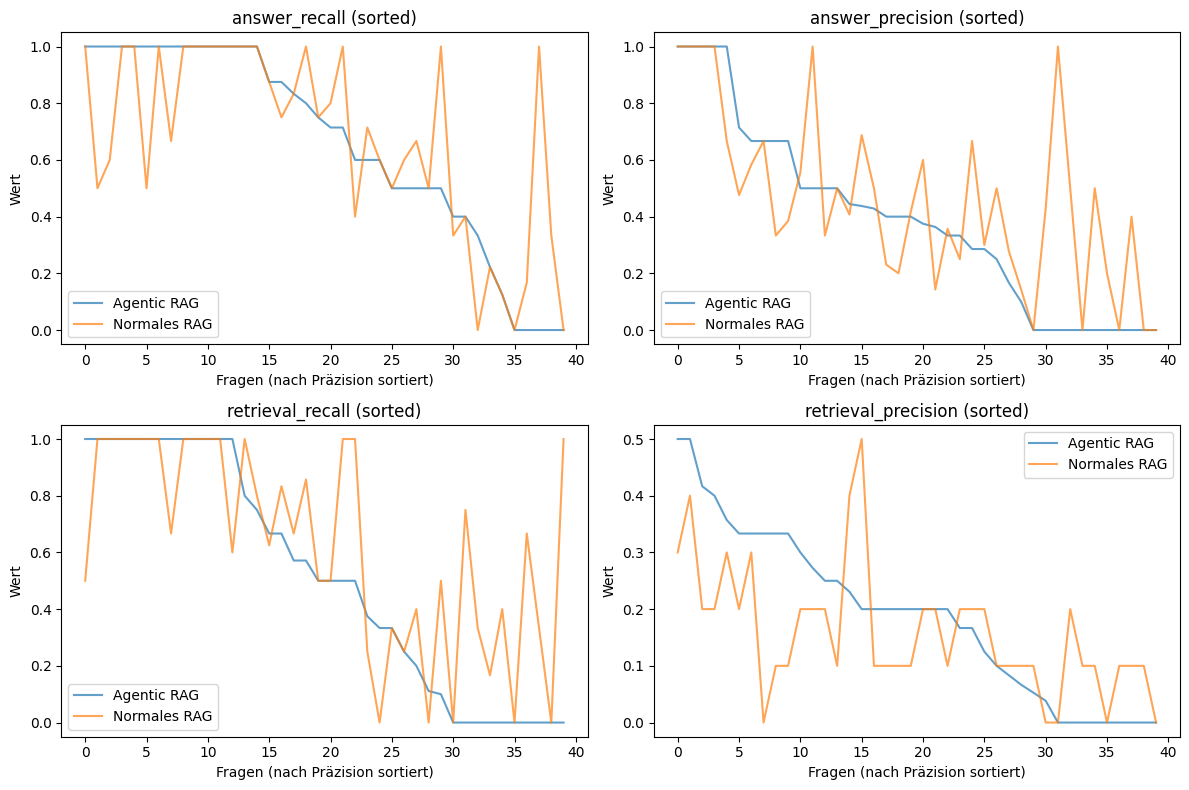

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# import data
df_agentic_rag = pd.read_csv("df_agentic.csv", index_col=False).drop(columns=["Unnamed: 0"])
df_plain_rag   = pd.read_csv("rag_runs/2025-09-09/df_plain_rag.csv", index_col=False).drop(columns=["Unnamed: 0"])

columns = df_agentic_rag.columns  

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, col in enumerate(columns):
    ax = axes[i//2, i%2]

    # sort both series by agentic metric value (descending)
    order = df_agentic_rag[col].sort_values(ascending=False).index
    agentic_sorted = df_agentic_rag.loc[order, col].reset_index(drop=True)
    plain_sorted   = df_plain_rag.loc[order, col].reset_index(drop=True)

    ax.plot(agentic_sorted.index, agentic_sorted, label="Agentic RAG", alpha=0.7)
    ax.plot(plain_sorted.index, plain_sorted, label="Normales RAG", alpha=0.7)

    ax.set_title(f"{col} (sorted)")
    ax.set_xlabel("Fragen (nach Pr√§zision sortiert)")
    ax.set_ylabel("Wert")
    ax.legend()

plt.tight_layout()
plt.show()

